In [2145]:
import pandas as pd
import seaborn as sns
from seaborn import load_dataset
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
import xgboost as xgb
from sklearn.svm import LinearSVC



In [2083]:
df = pd.read_csv('/Users/mikeredshaw/Documents/Schulich MBAN/AI in Business/Assignment 1 - Titanic/train.csv')
df_test = pd.read_csv('/Users/mikeredshaw/Documents/Schulich MBAN/AI in Business/Assignment 1 - Titanic/test.csv')


In [2084]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [2085]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [2086]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [2087]:
df_copy = df.copy()

In [2088]:
df = df.drop(['PassengerId', 'Cabin', 'Ticket'], axis=1)


In [2089]:
df['Title'] = df['Name'].str.split(',').str[1].str.split('.').str[0].str.strip()

In [2090]:
df['Title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: Title, dtype: int64

In [2091]:
title_counts = df['Title'].value_counts()
rare_titles = title_counts[title_counts < 10].index
df['Title'] = df['Title'].replace(rare_titles, 'Misc')


In [2092]:
df['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64

In [2093]:
df= df.drop(['Name'], axis=1)

In [2094]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,male,22.0,1,0,7.2500,S,Mr
1,1,1,female,38.0,1,0,71.2833,C,Mrs
2,1,3,female,26.0,0,0,7.9250,S,Miss
3,1,1,female,35.0,1,0,53.1000,S,Mrs
4,0,3,male,35.0,0,0,8.0500,S,Mr


In [2095]:
df.groupby('Sex')['Age'].mean()


Sex
female    27.915709
male      30.726645
Name: Age, dtype: float64

In [2096]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [2097]:
df['Age'] = df['Age'].fillna(df.groupby('Sex')['Age'].transform('mean'))
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [2098]:
label_encoder = LabelEncoder()

df['Embarked_Code'] = label_encoder.fit_transform(df['Embarked'])
df['Sex_Code'] = label_encoder.fit_transform(df['Sex'])
df['Title_Code'] = label_encoder.fit_transform(df['Title'])


In [2099]:
bin_ranges = [0, 5, 10, 15, 30, 40, 50, 60, 70, 80]  # Adjust the bin ranges as desired
labels = range(1, len(bin_ranges))  # Assign labels 1, 2, 3, 4, 5, and so on
df['Age_Bin'] = pd.cut(df['Age'], bins=bin_ranges, labels=labels).astype(int)

df['Fare_Bin'] = pd.qcut(df['Fare'], q=3, labels=[1, 2, 3]).astype(int)

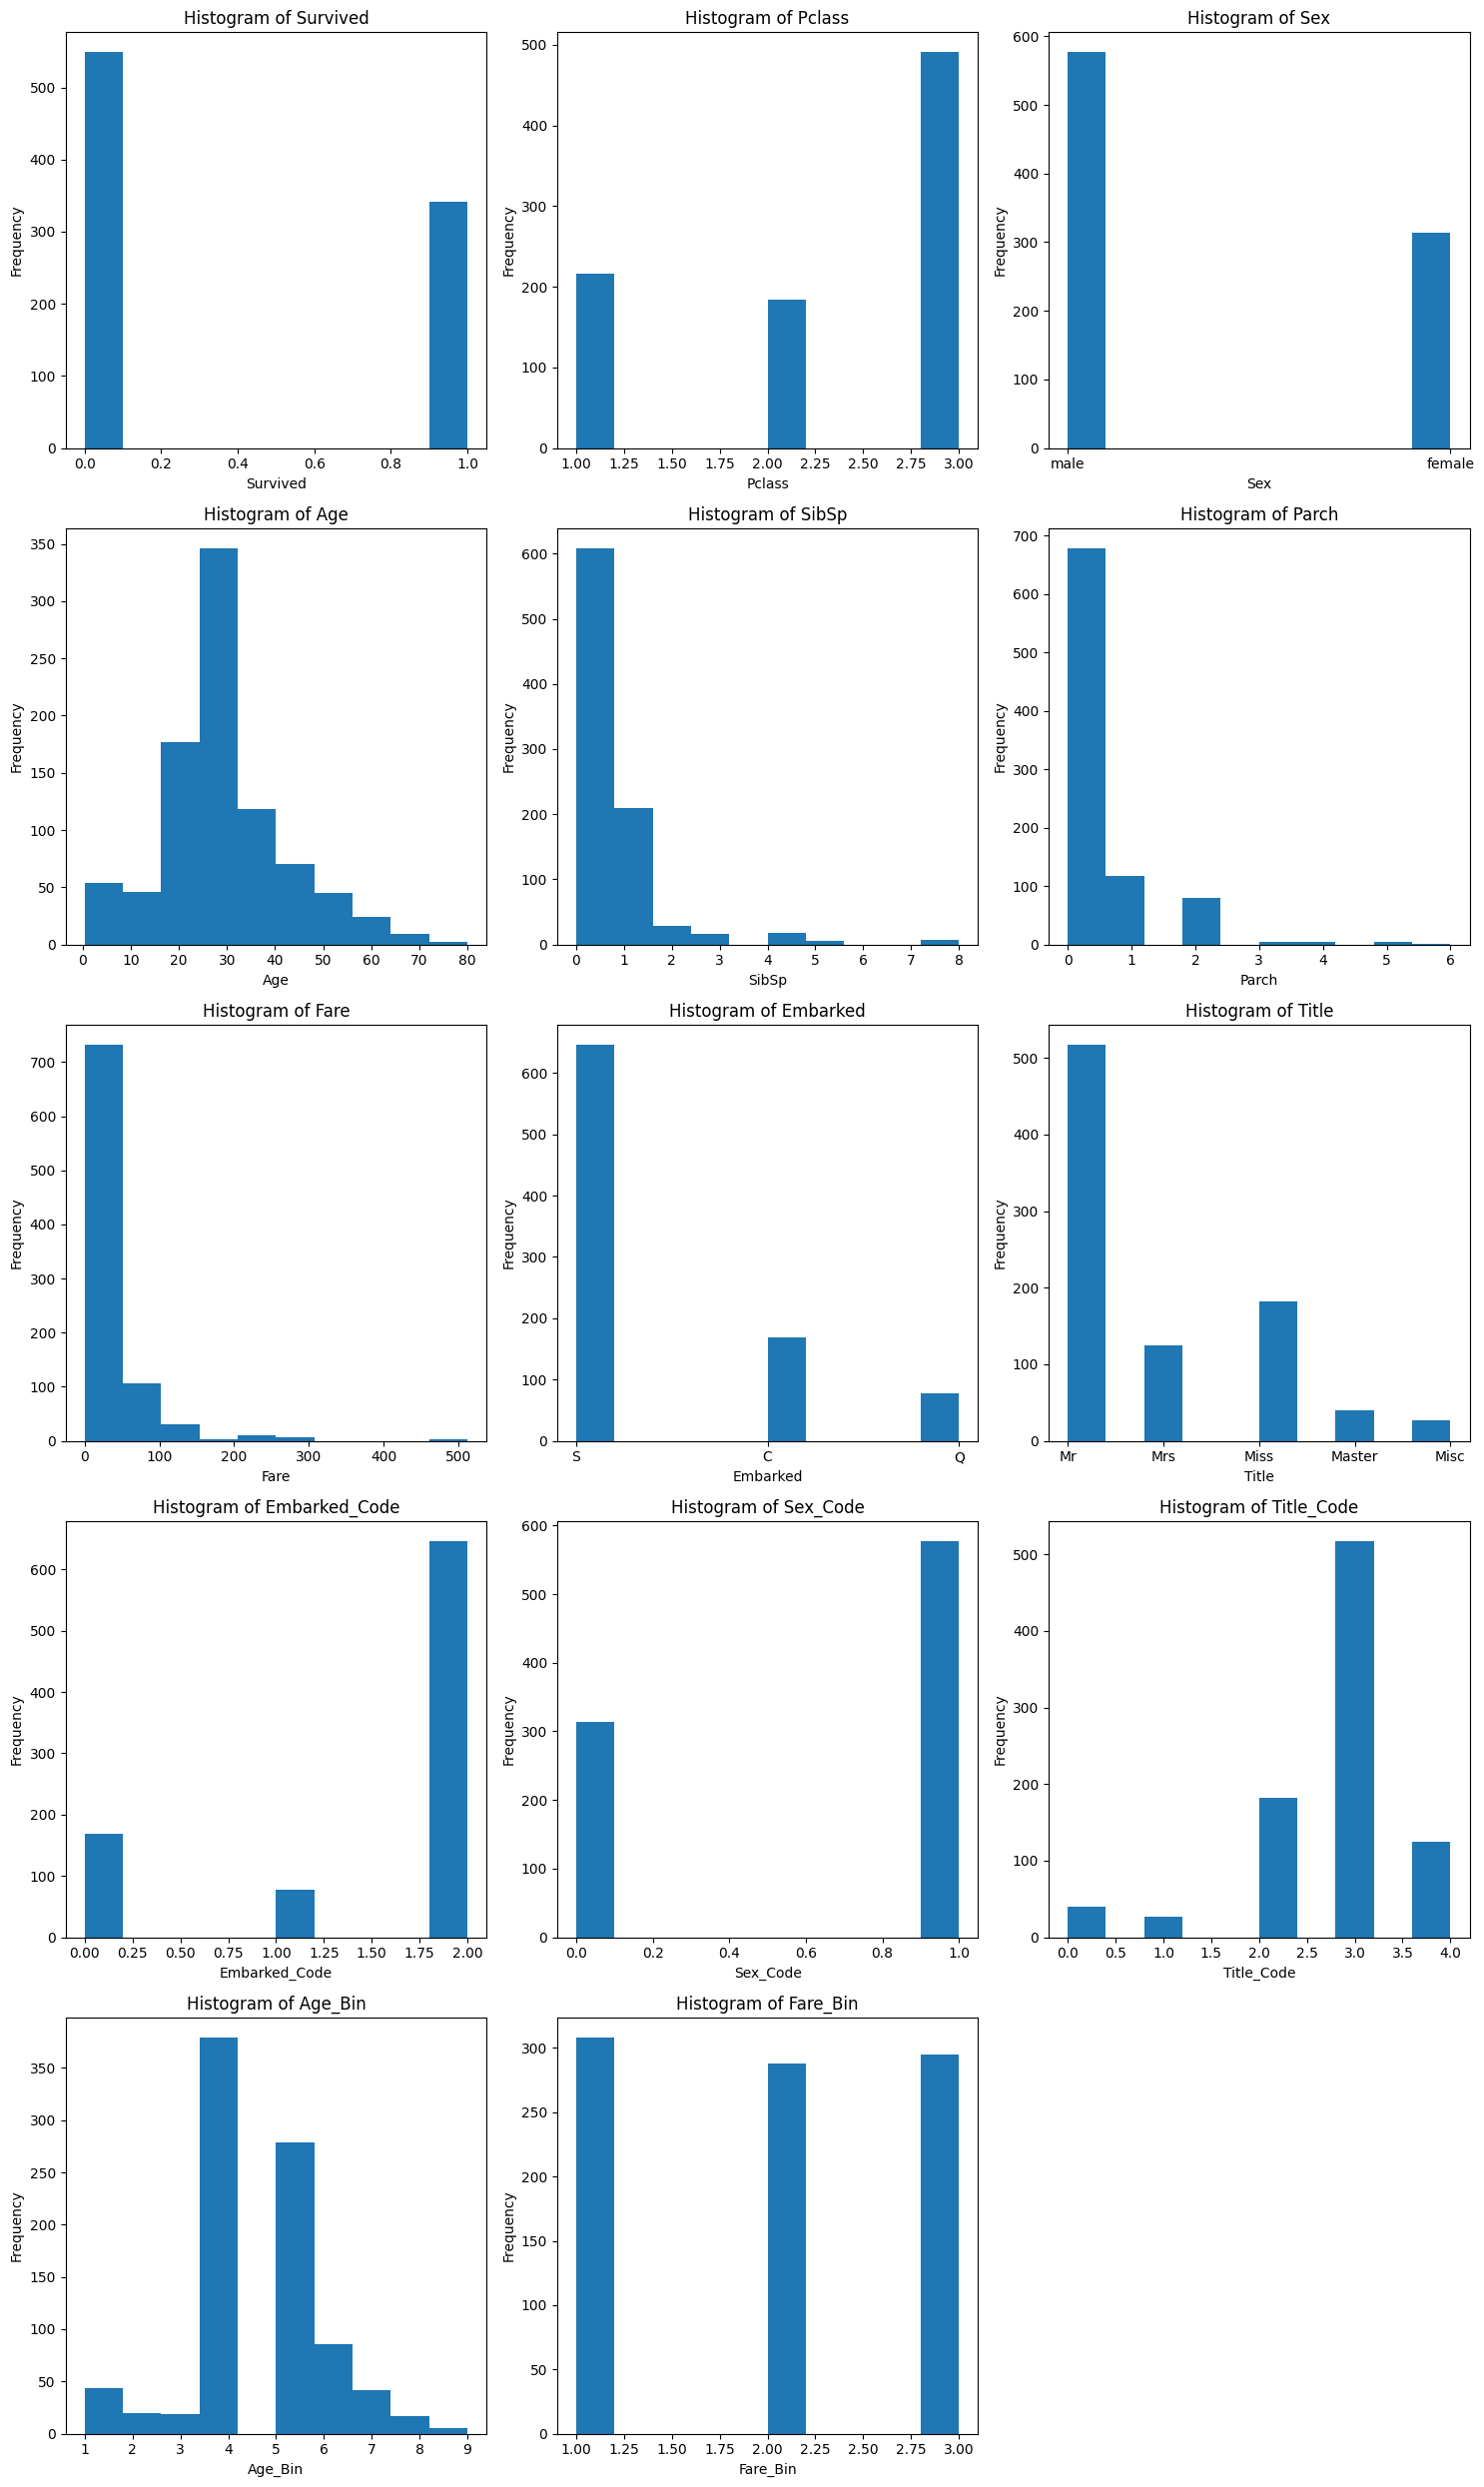

In [2100]:
num_plots = len(df.columns)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(df.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    df[column].hist(ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {column}')

# Remove empty subplots
if num_plots % 3 != 0:
    for i in range(num_plots, num_rows*3):
        fig.delaxes(axes[i // 3, i % 3])

plt.tight_layout()
for ax in axes.flatten():
    ax.grid(False)


In [2101]:
df.dtypes

Survived           int64
Pclass             int64
Sex               object
Age              float64
SibSp              int64
Parch              int64
Fare             float64
Embarked          object
Title             object
Embarked_Code      int64
Sex_Code           int64
Title_Code         int64
Age_Bin            int64
Fare_Bin           int64
dtype: object

In [2102]:
df['Child'] = ((df['Age'] < 16)).astype(int)
df['Elder'] = ((df['Age'] > 60)).astype(int)


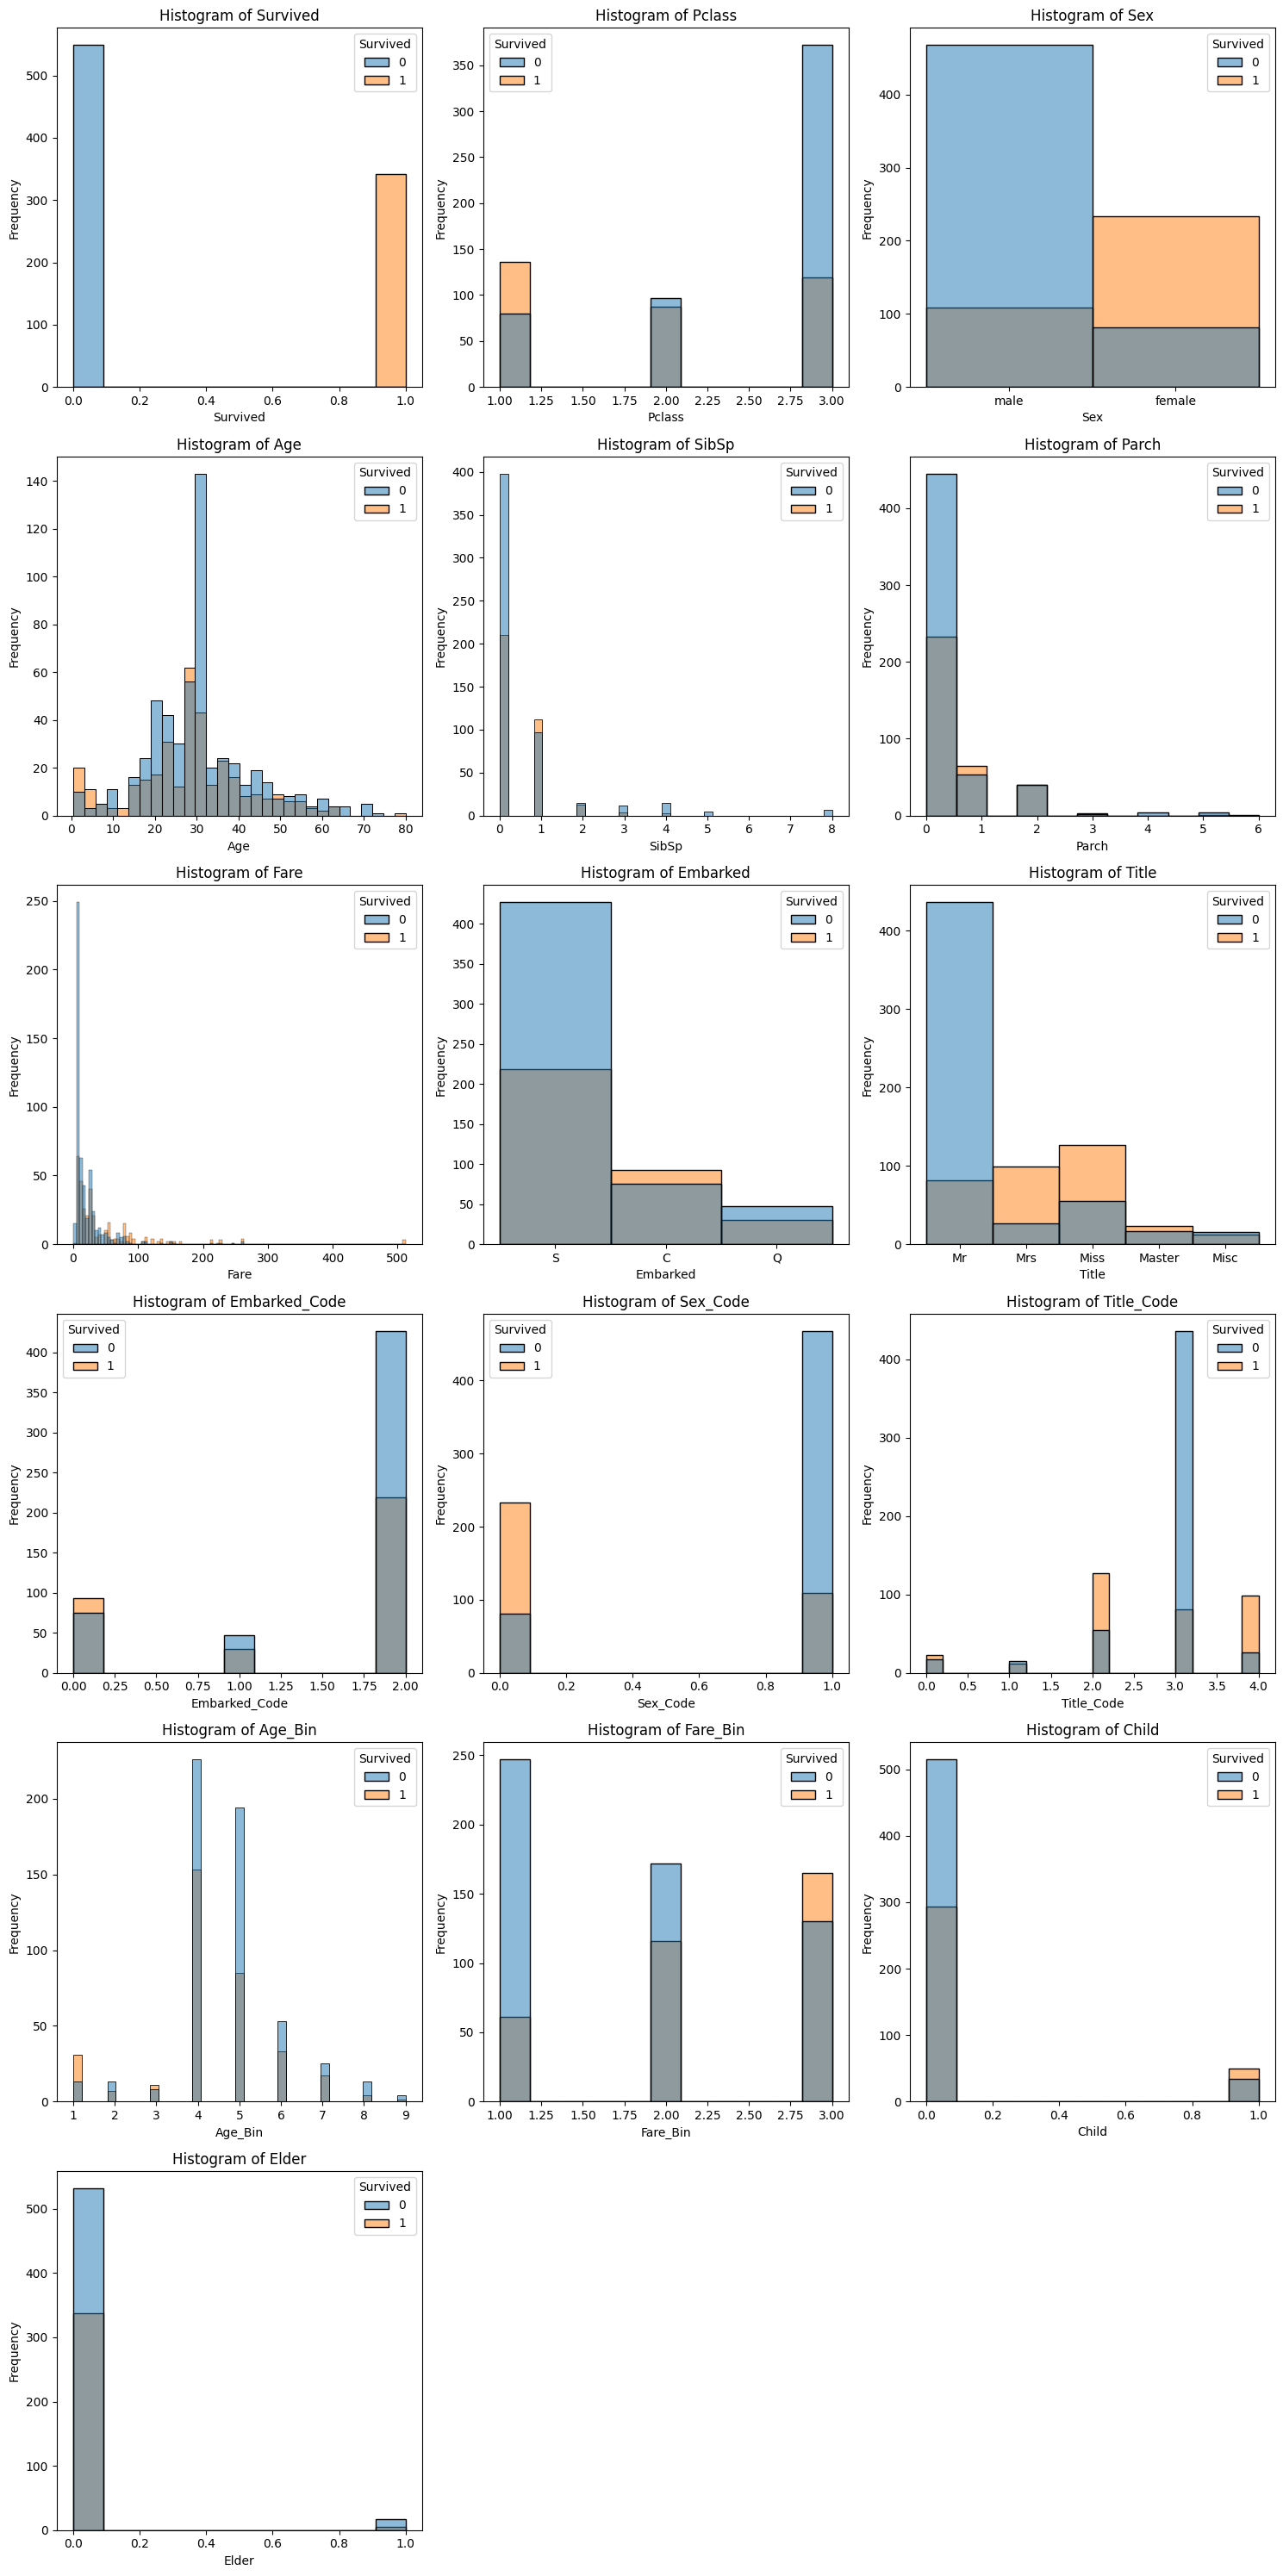

In [2103]:
num_plots = len(df.columns)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(df.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.histplot(data=df, x=column, hue='Survived', ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Histogram of {column}')

# Remove empty subplots
if num_plots % 3 != 0:
    for i in range(num_plots, num_rows*3):
        fig.delaxes(axes[i // 3, i % 3])

plt.tight_layout()
for ax in axes.flatten():
    ax.grid(False)

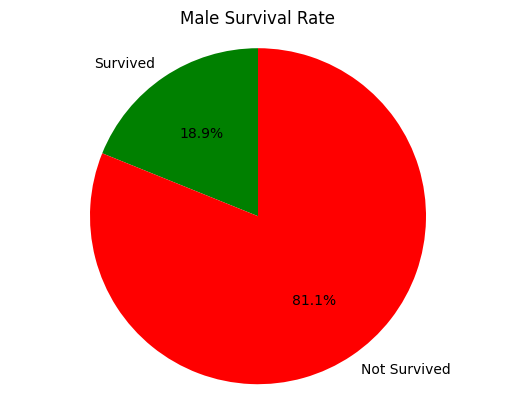

In [2104]:
# Count the number of males who survived and did not survive
male_survived = len(df_men[df_men['Survived'] == 1])
male_not_survived = len(df_men[df_men['Survived'] == 0])

# Create a pie chart
labels = ['Survived', 'Not Survived']
sizes = [male_survived, male_not_survived]
colors = ['green', 'red']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Male Survival Rate')
plt.show()



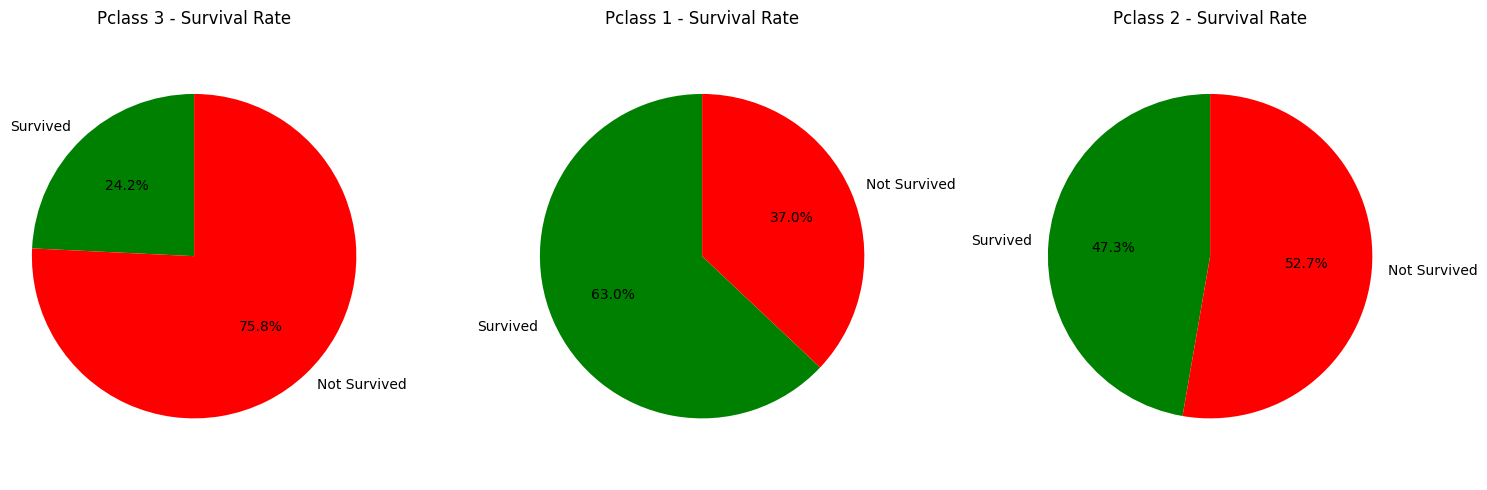

In [2105]:
survived_percentage = df.groupby('Pclass')['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, pclass in enumerate(df['Pclass'].unique()):
    labels = ['Survived', 'Not Survived']
    sizes = [survived_percentage[pclass], not_survived_percentage[pclass]]
    colors = ['green', 'red']
    
    ax = axes[i]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Pclass {pclass} - Survival Rate')

plt.tight_layout()
plt.show()


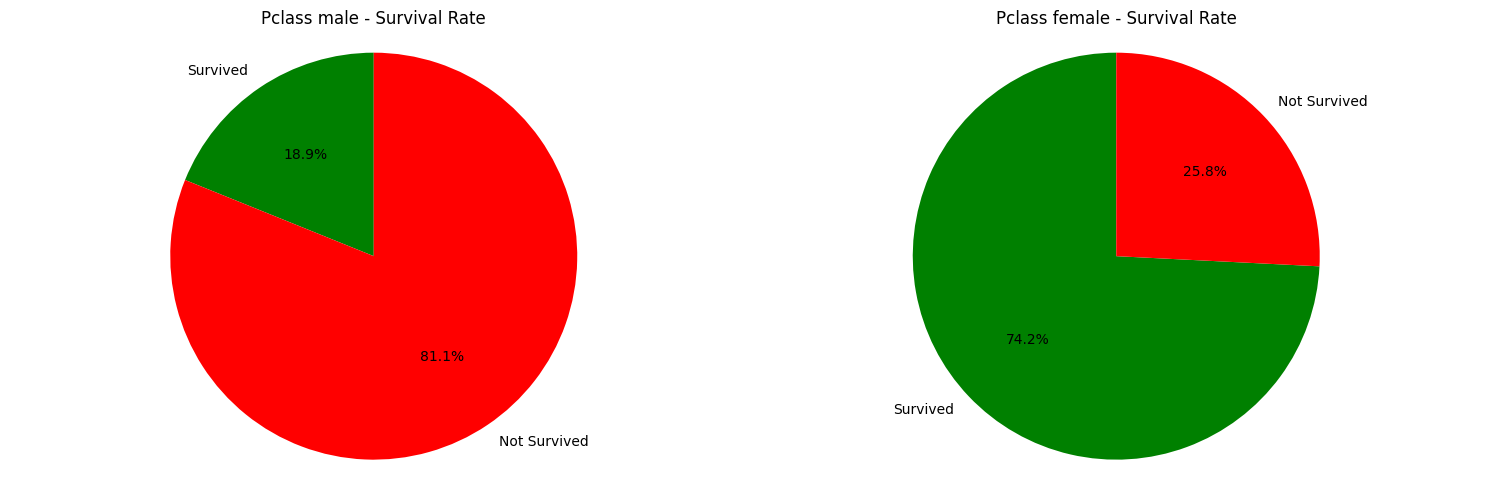

In [2106]:
survived_percentage = df.groupby('Sex')['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage


fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Iterate over each Pclass
for i, pclass in enumerate(df['Sex'].unique()):
    labels = ['Survived', 'Not Survived']
    sizes = [survived_percentage[pclass], not_survived_percentage[pclass]]
    colors = ['green', 'red']
    
    ax = axes[i]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Pclass {pclass} - Survival Rate')

plt.tight_layout()
plt.show()

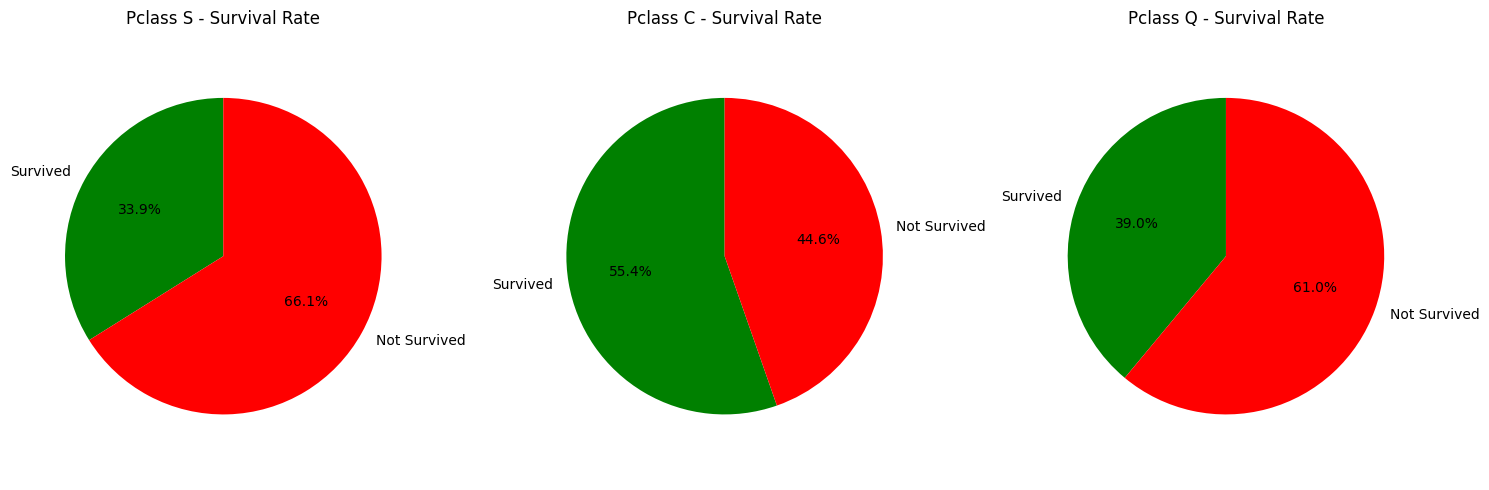

In [2107]:
survived_percentage = df.groupby('Embarked')['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, pclass in enumerate(df['Embarked'].unique()):
    labels = ['Survived', 'Not Survived']
    sizes = [survived_percentage[pclass], not_survived_percentage[pclass]]
    colors = ['green', 'red']
    
    ax = axes[i]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Pclass {pclass} - Survival Rate')

plt.tight_layout()
plt.show()

In [2108]:
df['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Misc'], dtype=object)

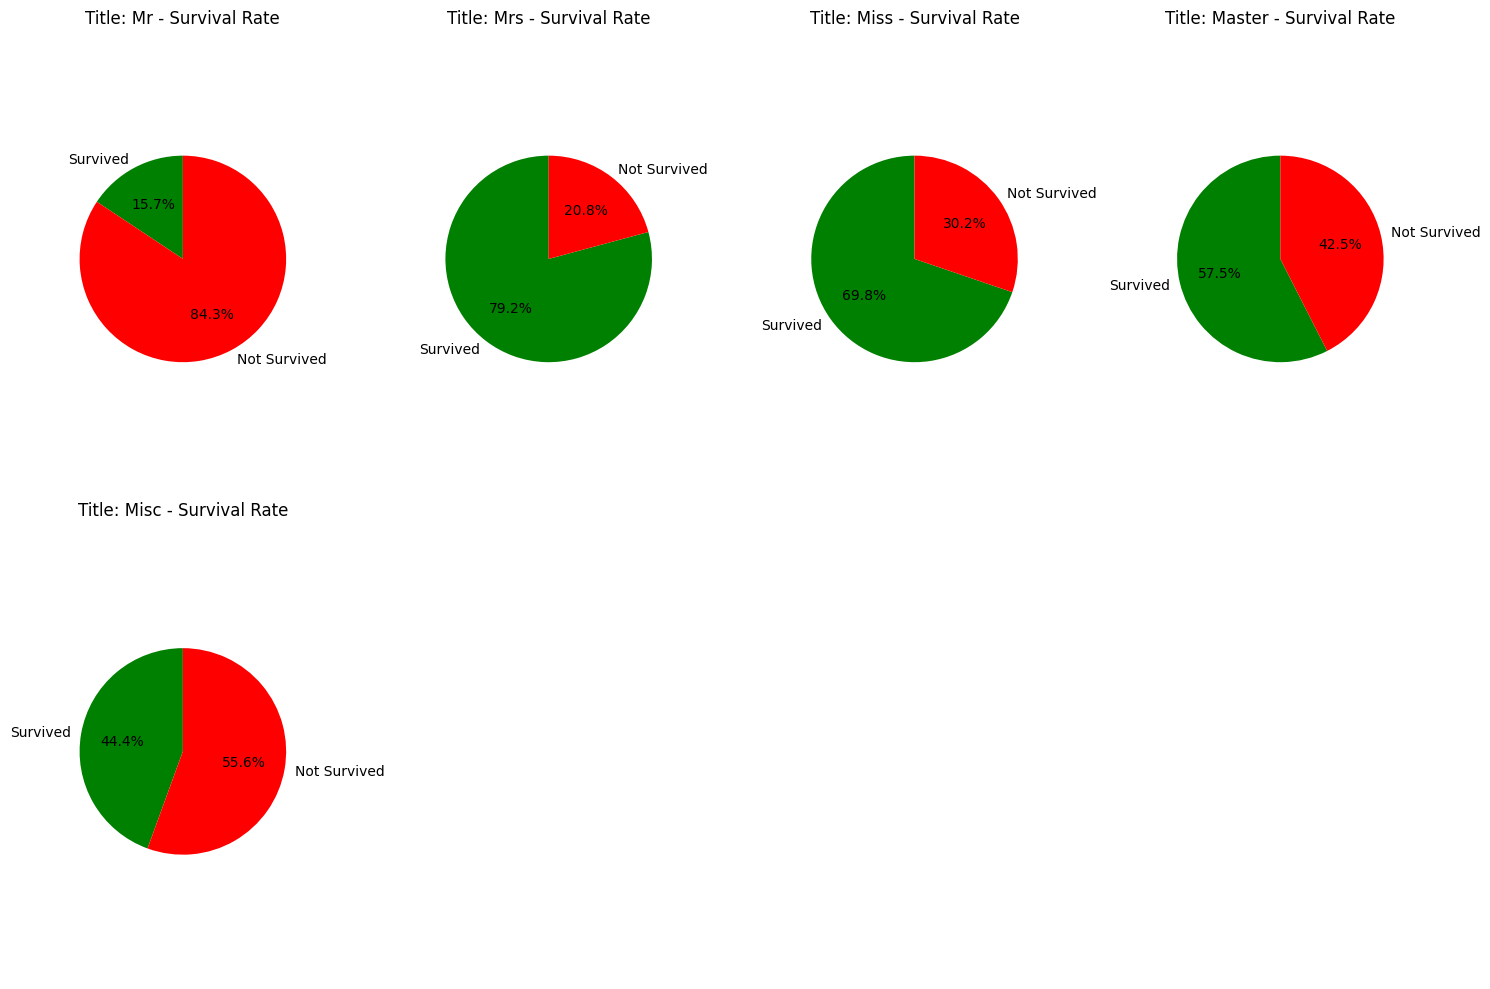

In [2109]:
survived_percentage = df.groupby('Title')['Survived'].mean() * 100
not_survived_percentage = 100 - survived_percentage

fig, axes = plt.subplots(2, 4, figsize=(15, 10))

for i, title in enumerate(df['Title'].unique()):
    row = i // 4
    col = i % 4
    
    labels = ['Survived', 'Not Survived']
    sizes = [survived_percentage[title], not_survived_percentage[title]]
    colors = ['green', 'red']
    
    ax = axes[row, col]
    ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f'Title: {title} - Survival Rate')
    
# Remove empty subplots
if len(df['Title'].unique()) < 8:
    for i in range(len(df['Title'].unique()), 8):
        fig.delaxes(axes[1, i % 4])

plt.tight_layout()


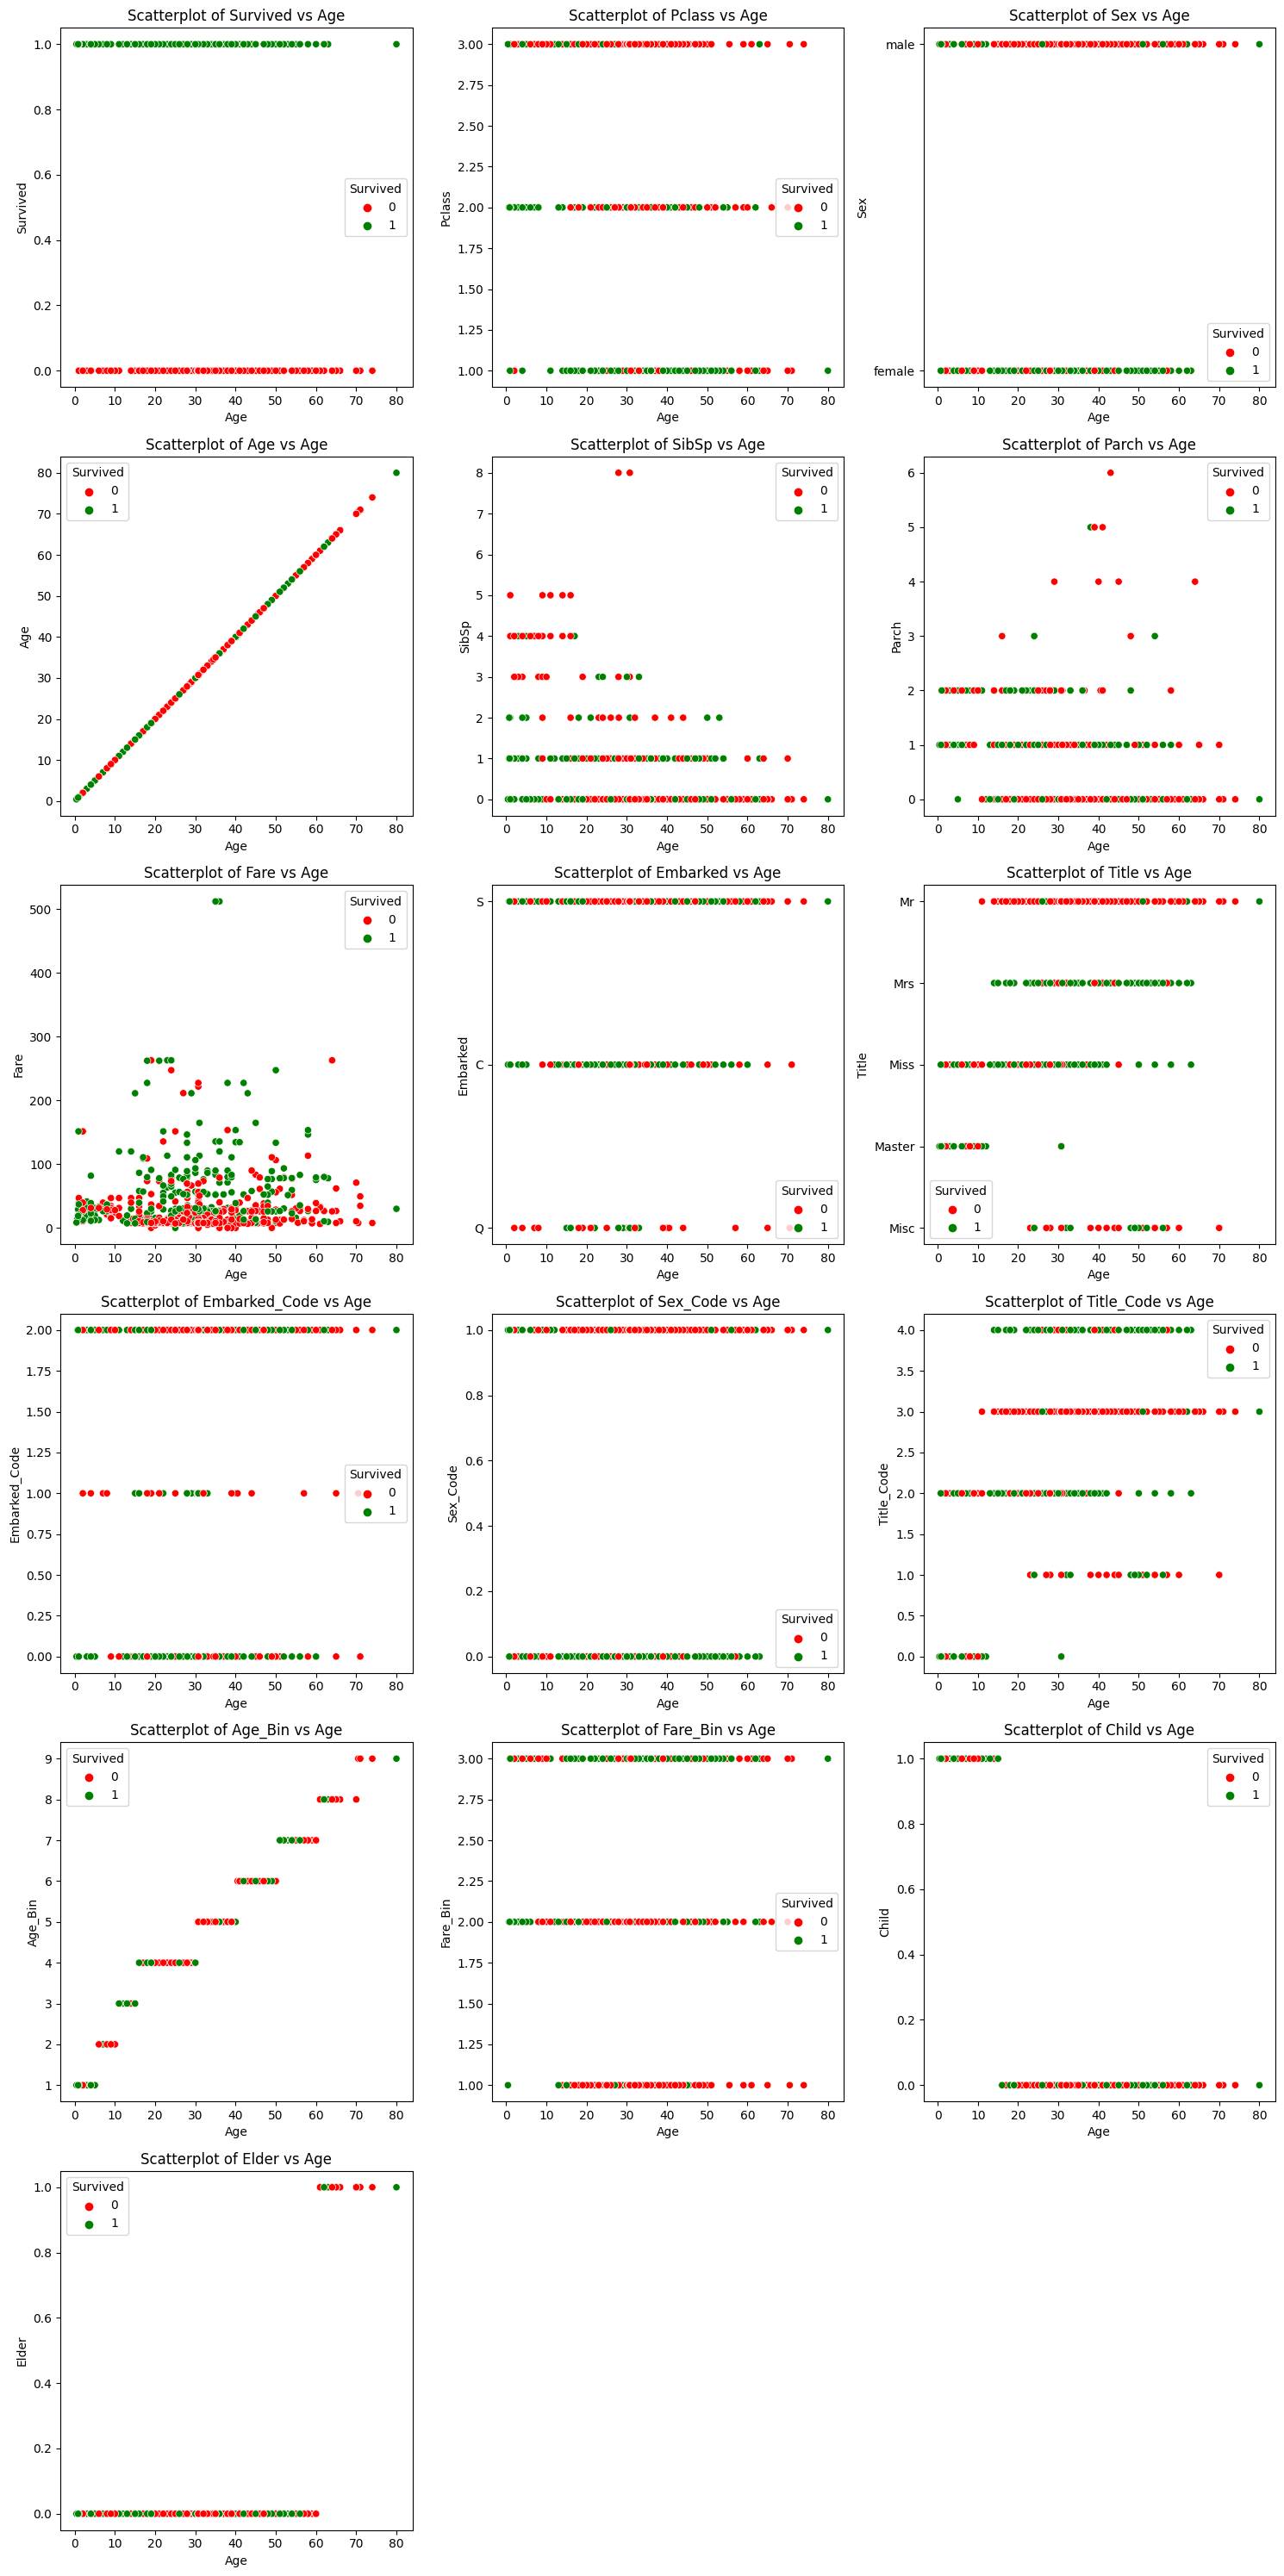

In [2110]:
num_plots = len(df.columns)
num_rows = (num_plots + 2) // 3
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(df.columns):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.scatterplot(data=df, x='Age', y=column, hue='Survived', palette=['red', 'green'], ax=ax)
    ax.set_xlabel('Age')
    ax.set_ylabel(column)
    ax.set_title(f'Scatterplot of {column} vs Age')

# Remove empty subplots
if num_plots % 3 != 0:
    for i in range(num_plots, num_rows*3):
        fig.delaxes(axes[i // 3, i % 3])

plt.tight_layout()
for ax in axes.flatten():
    ax.grid(False)


In [2111]:
df_men = df[df['Sex']== 'male']
df_women = df[df['Sex']== 'female']
df_child = df[df['Child']== 1]
df_Elder = df[df['Elder']== 1]

In [2112]:
print("Male Death Rate:", (len(df_men[df_men['Survived'] == 0]) / len(df_men)) * 100)
print("Female Death Rate:", (len(df_women[df_women['Survived'] == 0])/ len(df_women)) * 100)
print("Child Death Rate:", (len(df_child[df_child['Survived'] == 0])/ len(df_child)) * 100)
print("Elder Death Rate:", (len(df_Elder[df_Elder['Survived'] == 0])/ len(df_Elder)) * 100)

Male Death Rate: 81.10918544194108
Female Death Rate: 25.796178343949045
Child Death Rate: 40.963855421686745
Elder Death Rate: 77.27272727272727


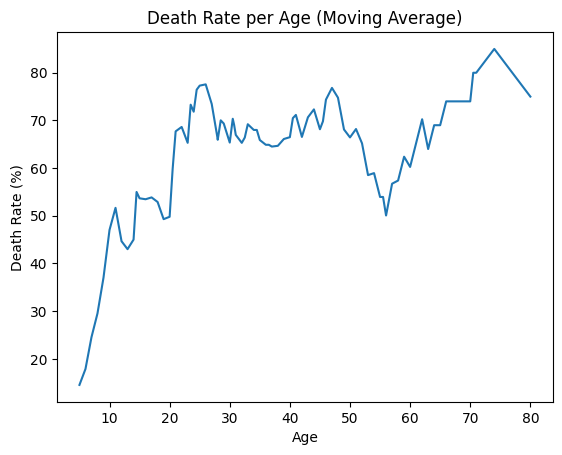

In [2113]:
death_rate_per_age = df.groupby(['Age'])['Survived'].apply(lambda x: (x == 0).sum() / len(x) * 100)

moving_average = death_rate_per_age.rolling(window=10).mean()
plt.plot(death_rate_per_age.index, moving_average)
plt.xlabel('Age')
plt.ylabel('Death Rate (%)')
plt.title('Death Rate per Age (Moving Average)')
plt.show()


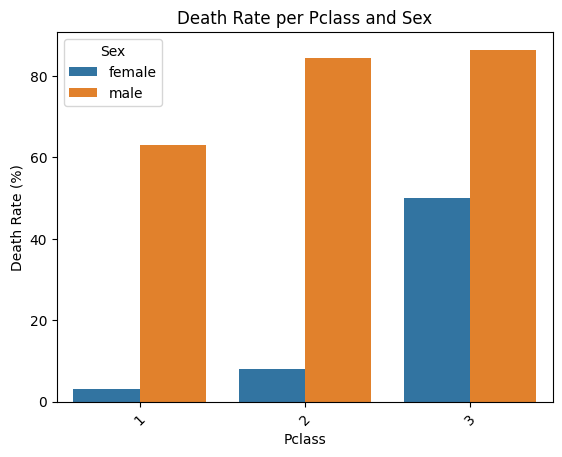

In [2114]:
death_rate_per_pclass = df.groupby(['Pclass', 'Sex'])['Survived'].apply(lambda x: (x == 0).sum() / len(x)*100)

sns.barplot(x=death_rate_per_pclass.index.get_level_values(0), y=death_rate_per_pclass.values, hue=death_rate_per_pclass.index.get_level_values(1))
plt.xlabel('Pclass')
plt.ylabel('Death Rate (%)')
plt.title('Death Rate per Pclass and Sex')
plt.xticks(rotation=45)
plt.legend(title='Sex')
plt.show()


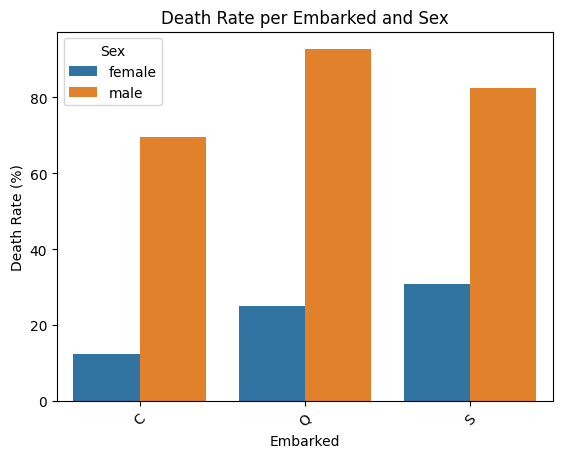

In [2115]:
death_rate_per_embarked = df.groupby(['Embarked', 'Sex'])['Survived'].apply(lambda x: (x == 0).sum() / len(x)*100)
sns.barplot(x=death_rate_per_embarked.index.get_level_values(0), y=death_rate_per_embarked.values, hue=death_rate_per_embarked.index.get_level_values(1))
plt.xlabel('Embarked')
plt.ylabel('Death Rate (%)')
plt.title('Death Rate per Embarked and Sex')
plt.xticks(rotation=45)
plt.legend(title='Sex')
plt.show()





In [2116]:
death_rate_per_SibSp = df.groupby('SibSp')['Survived'].apply(lambda x: (x == 0).sum() / len(x)*100)
print(death_rate_per_SibSp)

SibSp
0     65.460526
1     46.411483
2     53.571429
3     75.000000
4     83.333333
5    100.000000
8    100.000000
Name: Survived, dtype: float64


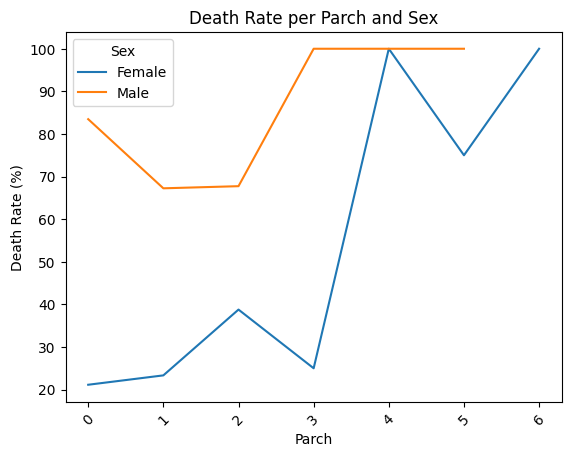

In [2117]:
death_rate_per_Parch = df.groupby(['Parch', 'Sex'])['Survived'].apply(lambda x: (x == 0).sum() / len(x)*100)

death_rate_per_Parch = death_rate_per_Parch.unstack()

plt.plot(death_rate_per_Parch.index, death_rate_per_Parch['female'], label='Female')
plt.plot(death_rate_per_Parch.index, death_rate_per_Parch['male'], label='Male')

plt.xlabel('Parch')
plt.ylabel('Death Rate (%)')
plt.title('Death Rate per Parch and Sex')
plt.xticks(rotation=45)
plt.legend(title='Sex')

plt.show()


In [2118]:
df['Fam_Size'] = df['SibSp'] + df['Parch'] + 1

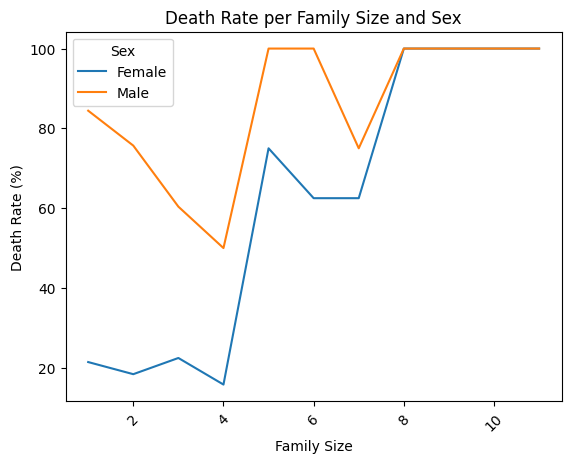

In [2119]:
death_rate_per_Fam_Size = df.groupby(['Fam_Size', 'Sex'])['Survived'].apply(lambda x: (x == 0).sum() / len(x)*100)
death_rate_per_Fam_Size = death_rate_per_Fam_Size.unstack()

plt.plot(death_rate_per_Fam_Size.index, death_rate_per_Fam_Size['female'], label='Female')
plt.plot(death_rate_per_Fam_Size.index, death_rate_per_Fam_Size['male'], label='Male')

plt.xlabel('Family Size')
plt.ylabel('Death Rate (%)')
plt.title('Death Rate per Family Size and Sex')
plt.xticks(rotation=45)
plt.legend(title='Sex')

plt.show()


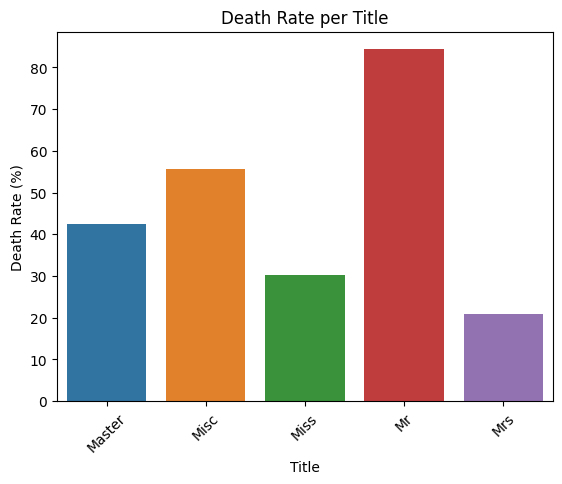

In [2120]:
death_rate_per_title = df.groupby('Title')['Survived'].apply(lambda x: (x == 0).sum() / len(x) * 100)
sns.barplot(x=death_rate_per_title.index, y=death_rate_per_title.values)
plt.xlabel('Title')
plt.ylabel('Death Rate (%)')
plt.title('Death Rate per Title')
plt.xticks(rotation=45)
plt.show()


In [2121]:
df['Alone'] = ((df['Fam_Size'] == 1)).astype(int)
df['Big_Fam'] = ((df['Fam_Size'] > 4)).astype(int)

In [2122]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Embarked_Code,Sex_Code,Title_Code,Age_Bin,Fare_Bin,Child,Elder,Fam_Size,Alone,Big_Fam
0,0,3,male,22.0,1,0,7.2500,S,Mr,2,1,3,4,1,0,0,2,0,0
1,1,1,female,38.0,1,0,71.2833,C,Mrs,0,0,4,5,3,0,0,2,0,0
2,1,3,female,26.0,0,0,7.9250,S,Miss,2,0,2,4,1,0,0,1,1,0
3,1,1,female,35.0,1,0,53.1000,S,Mrs,2,0,4,5,3,0,0,2,0,0
4,0,3,male,35.0,0,0,8.0500,S,Mr,2,1,3,5,1,0,0,1,1,0


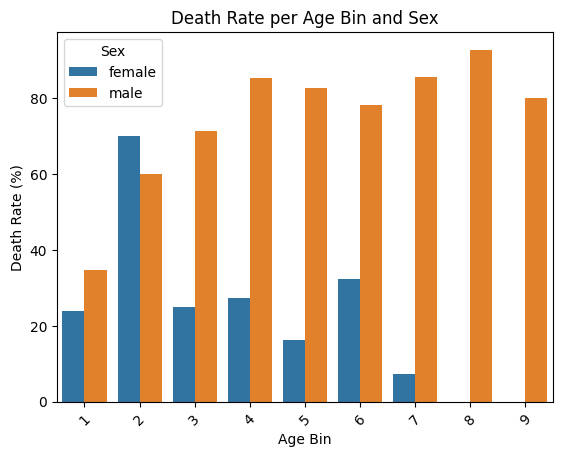

In [2123]:
death_rate_per_age_bin_sex = df.groupby(['Age_Bin', 'Sex'])['Survived'].apply(lambda x: (x == 0).sum() / len(x) * 100)
sns.barplot(x=death_rate_per_age_bin_sex.index.get_level_values(0), y=death_rate_per_age_bin_sex.values, hue=death_rate_per_age_bin_sex.index.get_level_values(1))
plt.xlabel('Age Bin')
plt.ylabel('Death Rate (%)')
plt.title('Death Rate per Age Bin and Sex')
plt.xticks(rotation=45)
plt.legend(title='Sex')
plt.show()


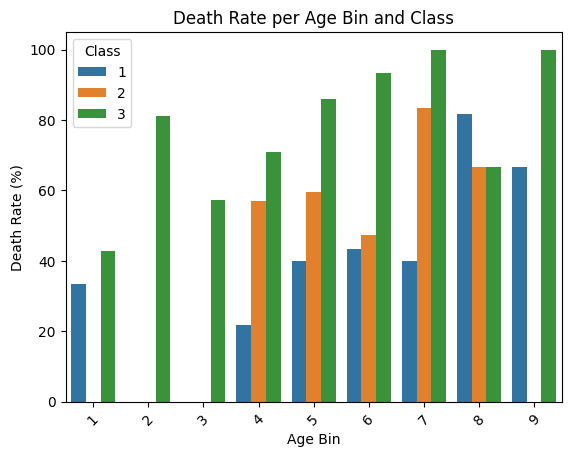

In [2124]:
death_rate_per_age_bin_class = df.groupby(['Age_Bin', 'Pclass'])['Survived'].apply(lambda x: (x == 0).sum() / len(x) * 100)
sns.barplot(x=death_rate_per_age_bin_class.index.get_level_values(0), y=death_rate_per_age_bin_class.values, hue=death_rate_per_age_bin_class.index.get_level_values(1))
plt.xlabel('Age Bin')
plt.ylabel('Death Rate (%)')
plt.title('Death Rate per Age Bin and Class')
plt.xticks(rotation=45)
plt.legend(title='Class')
plt.show()

Main takeaways so far: Being a 3rd class adult male with a large family size, or traveling alone, has a dramatically higher chance of death.

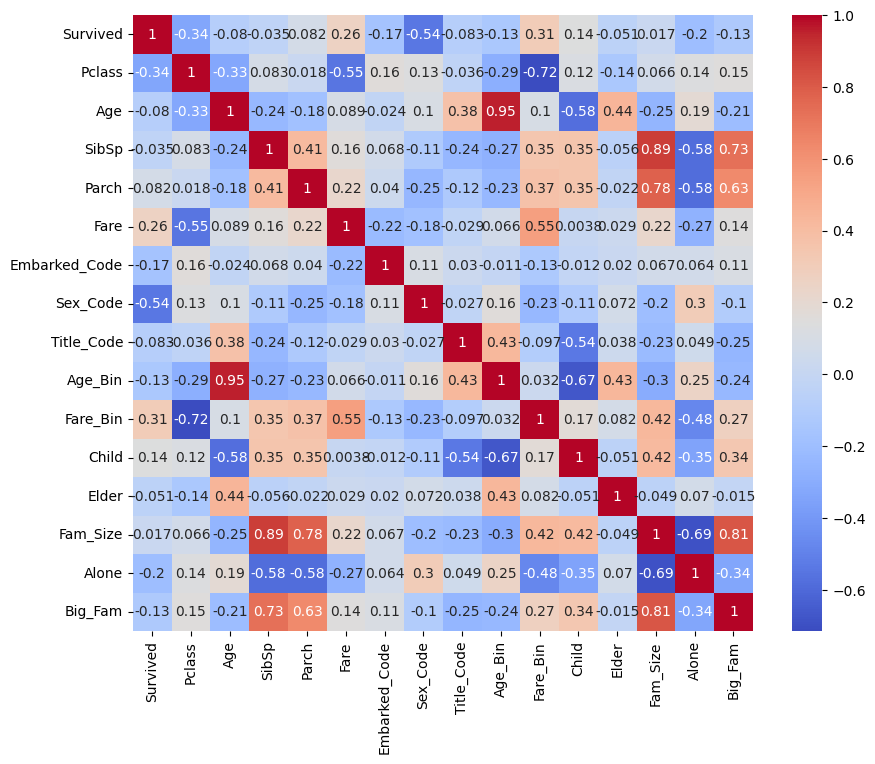

In [2125]:
correlation_matrix = df.corr()

# Create a larger heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

# Display the heatmap
plt.show()


In [2126]:
correlation_matrix = df.corr()
survived_correlation = correlation_matrix['Survived'].sort_values(ascending=False)
print(survived_correlation)


Survived         1.000000
Fare_Bin         0.305799
Fare             0.257307
Child            0.136107
Parch            0.081629
Fam_Size         0.016639
SibSp           -0.035322
Elder           -0.051224
Age             -0.080453
Title_Code      -0.083292
Big_Fam         -0.125147
Age_Bin         -0.134327
Embarked_Code   -0.167675
Alone           -0.203367
Pclass          -0.338481
Sex_Code        -0.543351
Name: Survived, dtype: float64


In [2127]:
df.dtypes

Survived           int64
Pclass             int64
Sex               object
Age              float64
SibSp              int64
Parch              int64
Fare             float64
Embarked          object
Title             object
Embarked_Code      int64
Sex_Code           int64
Title_Code         int64
Age_Bin            int64
Fare_Bin           int64
Child              int64
Elder              int64
Fam_Size           int64
Alone              int64
Big_Fam            int64
dtype: object

In [2128]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Title', 'Embarked_Code', 'Sex_Code', 'Title_Code',
       'Age_Bin', 'Fare_Bin', 'Child', 'Elder', 'Fam_Size', 'Alone',
       'Big_Fam'],
      dtype='object')

In [2129]:
cat_columns = ['Pclass', 'Sex_Code', 'Embarked_Code', 'Child', 'Elder', 'Age_Bin', 'Alone', 'Big_Fam', 'Title_Code', 'Fare_Bin']
num_columns = ['Parch']
target = 'Survived'

In [2130]:
# First split: 80% for training and 20% for testing + validation
X_train_temp, X_test_valid, y_train_temp, y_test_valid = train_test_split(df[cat_columns + num_columns], df[target], test_size=0.3, random_state=42)

# Second split: Split the 20% into testing and validation (50% each of 20% -> 10% each of total data)
X_test, X_valid, y_test, y_valid = train_test_split(X_test_valid, y_test_valid, test_size=0.5, random_state=42)

In [2131]:
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])
preprocessor = ColumnTransformer(transformers=[('cat', cat_transformer, cat_columns),
                                               ('num', num_transformer, num_columns)])


In [2132]:
X_train_transformed = preprocessor.fit_transform(X_train_temp)
X_test_transformed = preprocessor.transform(X_test)
X_valid_transformed = preprocessor.transform(X_valid)

In [2133]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [5000, 10000] 
}

grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)


best_params = grid_search.best_params_
print("Best parameters found:", best_params)

best_model = grid_search.best_estimator_


linear_predict_test = best_model.predict(X_test_transformed)
print("Test set accuracy:", metrics.accuracy_score(y_test, linear_predict_test))

linear_predict_valid = best_model.predict(X_valid_transformed)
print("Validation set accuracy:", metrics.accuracy_score(y_valid, linear_predict_valid))


Best parameters found: {'C': 1, 'max_iter': 5000}
Test set accuracy: 0.8432835820895522
Validation set accuracy: 0.7985074626865671


In [2142]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train_transformed, y_train_temp)  # Ensure to use the transformed training data
feature_importance = dt_model.feature_importances_
feature_names = X_train_temp.columns

feature_importance_with_names = dict(zip(feature_names, feature_importance))
sorted_features = sorted(feature_importance_with_names.items(), key=lambda x: x[1], reverse=True)
df_feature_importance = pd.DataFrame(sorted_features, columns=['Feature', 'Importance'])
print(df_feature_importance)

          Feature  Importance
0   Embarked_Code    0.138406
1           Child    0.026704
2        Sex_Code    0.023638
3         Age_Bin    0.020314
4         Big_Fam    0.012249
5           Alone    0.004037
6          Pclass    0.002512
7      Title_Code    0.002055
8        Fare_Bin    0.000944
9           Elder    0.000000
10          Parch    0.000000


In [2134]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'base_estimator__max_depth': [1, 3, 5, None],
    'base_estimator__min_samples_split': [2, 4, 6]
}

bag_model = BaggingClassifier(estimator=DecisionTreeClassifier())
grid_search = GridSearchCV(bag_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)

best_params = grid_search.best_params_
print("Best parameters found:", best_params)

best_bag_model = grid_search.best_estimator_

# Predict and evaluate on test set
bag_pred_test = best_bag_model.predict(X_test_transformed)
print("Test set accuracy:", metrics.accuracy_score(y_test, bag_pred_test))

# Predict and evaluate on validation set
bag_pred_valid = best_bag_model.predict(X_valid_transformed)
print("Validation set accuracy:", metrics.accuracy_score(y_valid, bag_pred_valid))



Best parameters found: {'base_estimator__max_depth': None, 'base_estimator__min_samples_split': 6, 'n_estimators': 100}
Test set accuracy: 0.8432835820895522
Validation set accuracy: 0.7611940298507462


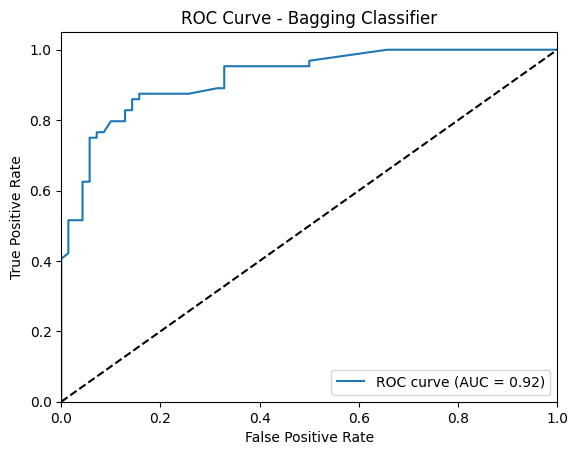

In [2135]:
# ROC Curve and AUC for test set
bag_predict_proba_test = best_bag_model.predict_proba(X_test_transformed)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, bag_predict_proba_test)
bag_auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % bag_auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bagging Classifier')
plt.legend(loc="lower right")
plt.show()

In [2136]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train_temp)

best_params = grid_search.best_params_
print("Best parameters found:", best_params)

best_rf_model = grid_search.best_estimator_
rf_predict_test = best_rf_model.predict(X_test_transformed)



rf_predict_valid = best_rf_model.predict(X_valid_transformed)
print("Validation set accuracy:", metrics.accuracy_score(y_valid, rf_predict_valid))


Best parameters found: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 50}
Test set accuracy: 0.835820895522388
Validation set accuracy: 0.7910447761194029


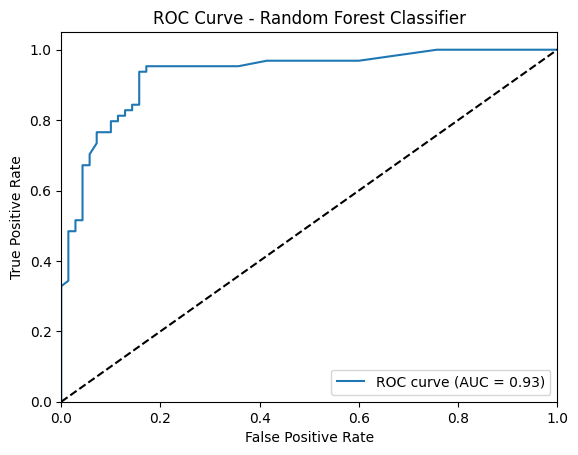

In [2137]:
# ROC Curve and AUC for test set
rf_predict_proba_test = best_rf_model.predict_proba(X_test_transformed)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, rf_predict_proba_test)
rf_auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % rf_auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest Classifier')
plt.legend(loc="lower right")
plt.show()

In [2147]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.01, 0.001]
}

xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train_transformed, y_train_temp)


best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_xgb_model = grid_search.best_estimator_

xgb_predict_test = best_xgb_model.predict(X_test_transformed)


xgb_accuracy_score_test =  metrics.accuracy_score(y_test, xgb_predict_test)
xgb_f1_score_test = f1_score(y_test, xgb_predict_test)
xgb_auc_score_test = roc_auc_score(y_test, xgb_predict_test)


xgb_predict_valid = best_xgb_model.predict(X_valid_transformed)
xgb_accuracy_score_valid =  metrics.accuracy_score(y_valid, xgb_predict_valid)
xgb_f1_score_valid = f1_score(y_valid, xgb_predict_valid)
xgb_auc_score_valid = roc_auc_score(y_valid, xgb_predict_valid)






Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 200}
Test set accuracy: 0.8582089552238806
Test set F1 score: 0.8403361344537814
Test set AUC score: 0.8549107142857143
Validation set accuracy: 0.8134328358208955
Validation set F1 score: 0.7252747252747254
Validation set AUC score: 0.7878454389826364


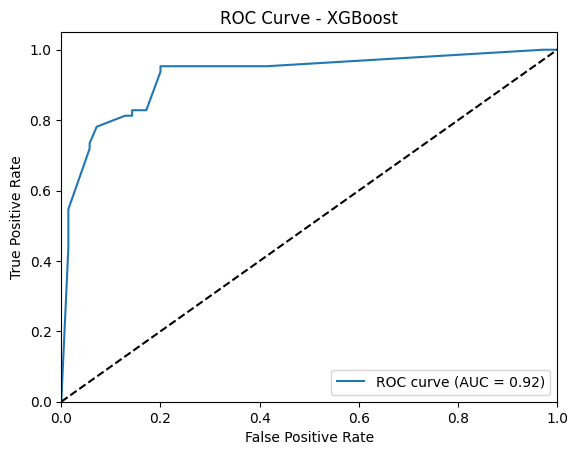

In [2141]:
# ROC Curve and AUC for test set
xgb_predict_proba_test = best_xgb_model.predict_proba(X_test_transformed)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, xgb_predict_proba_test)
xgb_auc_score = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % xgb_auc_score)
plt.plot([0, 1], [0, 1], 'k--')  # Plot the diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc="lower right")
plt.show()